# Guía 7

## Ejercicio 2

Suponga que un viajante tiene que visitar n ciudades en el menor tiempo posible. Considere una matriz D de tamaño $n × n$ cuyos elementos $d_{pq}$ denotan la distancia entre cada par de ciudades (p, q). Se define un recorrido como una trayectoria cerrada que visita cada ciudad una y s ́olo una vez (a excepción de la ciudad de partida, a la cual debe regresar). El problema consiste en hallar el recorrido de mínima longitud.

Implemente el algoritmo de sistema de hormigas y utilícelo para resolver el problema del agente viajero considerando los datos proporcionados en el archivo gr17.csv.

Analice el efecto de la tasa de evaporación (ρ) y de la cantidad de feromona depositada (τ) sobre los resultados de la búsqueda. Para esto ́ultimo compare el desempeño del algoritmo empleando los métodos global, local y uniforme para depósito de feromonas. Realice varias corridas con cada configuración experimental y considere el tiempo de búsqueda y la longitud de los caminos encontrados como medidas para comparar el desempeño. Construya una tabla comparativa con los resultados obtenidos.



In [1]:
import numpy as np  
from ACO import ACO
from prettytable import PrettyTable

# Cargar matriz de distancias
G = np.loadtxt("./data/gr17.csv", delimiter=',')

# Parámetros
cant_hormigas = 10
tasa_evaporacion = [0.1, 0.5, 0.9]
feromonas_depositadas = [0.1, 1, 10]
metodos = ['global', 'local', 'uniforme']
alpha = 1.0
beta = 1.0
max_it = 400
n_runs = 10

# Tabla de resultados
resultados = PrettyTable(["rho", "q", "metodo", "avg_time", "avg_dist", "avg_it", "last path"])

# Iterar combinaciones de parámetros
for rho in tasa_evaporacion:
    for q in feromonas_depositadas:
        for metodo in metodos:
            tiempos = []
            dists = []
            caminos = []
            its = []

            for run in range(n_runs):
                aco = ACO(cant_hormigas, rho, q, metodo, alpha, beta, max_it)
                # llamar buscar solo con ciudad inicial
                total_time, best_length, best_path, it = aco.buscar(G, start=0)

                tiempos.append(total_time)
                dists.append(best_length)
                caminos.append(best_path)
                its.append(it)  
            
            # Promedios
            avg_time = np.mean(tiempos)
            avg_dist = np.mean(dists)
            avg_it = np.mean(its)   

            # Convertir último camino a enteros nativos
            path_int = [int(n) for n in caminos[-1]]
            resultados.add_row([rho, q, metodo, f"{avg_time:.4f}", f"{avg_dist:.2f}", f"{avg_it:.2f}", str(path_int)])

# Mostrar resultados
print(resultados)


+-----+-----+----------+----------+----------+--------+---------------------------------------------------------------+
| rho |  q  |  metodo  | avg_time | avg_dist | avg_it |                           last path                           |
+-----+-----+----------+----------+----------+--------+---------------------------------------------------------------+
| 0.1 | 0.1 |  global  |  0.0991  | 2869.70  |  9.60  | [0, 5, 7, 12, 3, 6, 16, 13, 2, 8, 15, 11, 10, 9, 1, 4, 14, 0] |
| 0.1 | 0.1 |  local   |  0.0743  | 2795.60  | 11.10  | [0, 7, 16, 6, 11, 3, 12, 13, 5, 2, 14, 4, 10, 9, 1, 8, 15, 0] |
| 0.1 | 0.1 | uniforme |  0.0892  | 2341.80  | 16.10  | [0, 16, 3, 12, 6, 7, 5, 13, 2, 14, 10, 4, 9, 1, 8, 11, 15, 0] |
| 0.1 |  1  |  global  |  0.0400  | 2906.10  |  7.50  | [0, 13, 7, 16, 5, 14, 2, 6, 3, 12, 8, 11, 15, 10, 9, 4, 1, 0] |
| 0.1 |  1  |  local   |  0.0515  | 2912.30  | 10.30  | [0, 6, 9, 14, 10, 4, 1, 2, 12, 3, 13, 7, 11, 8, 15, 5, 16, 0] |
| 0.1 |  1  | uniforme |  0.0532  | 2303

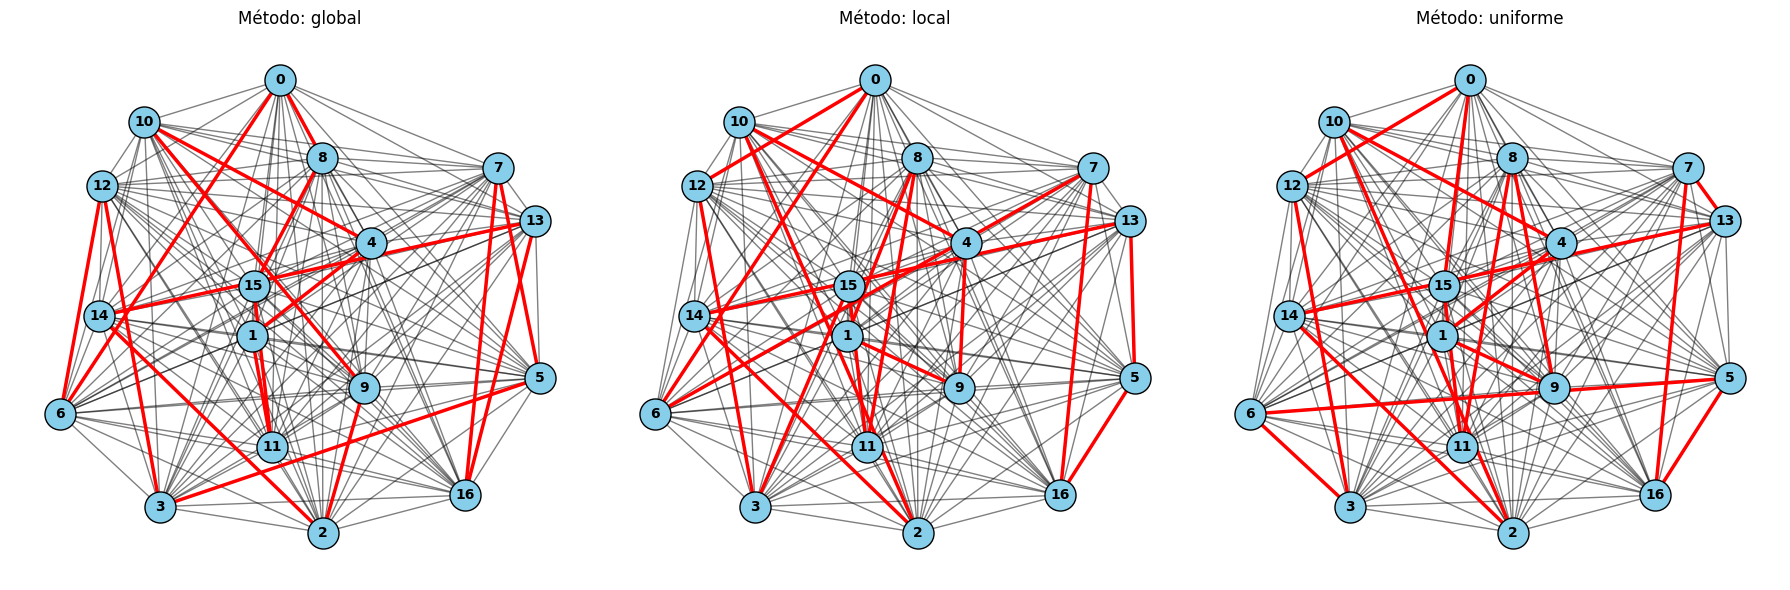

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

# construir el grafo base
G_nx = nx.Graph()
for i in range(G.shape[0]):
    for j in range(i + 1, G.shape[1]):
        if G[i, j] > 0:
            G_nx.add_edge(i, j, weight=G[i, j])

# layout fijo para todos los gráficos
pos = nx.spring_layout(G_nx, seed=42)

# graficar cada método
fig, axes = plt.subplots(1, len(metodos), figsize=(6*len(metodos), 6))

if len(metodos) == 1:
    axes = [axes]  # asegurar que sea iterable

for ax, metodo in zip(axes, metodos):
    # tomar el último camino de cada método
    # filtramos caminos que correspondan al método actual
    idx = [i for i, row in enumerate(resultados._rows) if row[2] == metodo]
    if not idx:
        continue
    # usamos el último run para ese método
    best_path = eval(resultados._rows[idx[-1]][-1])  # convertir string a lista

    # convertir a aristas
    edges_in_path = [(best_path[i], best_path[i+1]) for i in range(len(best_path)-1)]

    # dibujar todas las aristas
    nx.draw_networkx_edges(G_nx, pos, ax=ax, alpha=0.5)
    # dibujar camino del ACO
    nx.draw_networkx_edges(G_nx, pos, ax=ax, edgelist=edges_in_path, edge_color='r', width=2.5)
    # nodos
    nx.draw_networkx_nodes(G_nx, pos, ax=ax, node_color='skyblue', node_size=500, edgecolors='k')
    nx.draw_networkx_labels(G_nx, pos, ax=ax, font_size=10, font_weight='bold')
    ax.set_title(f"Método: {metodo}")
    ax.axis('off')

plt.tight_layout()
plt.show()


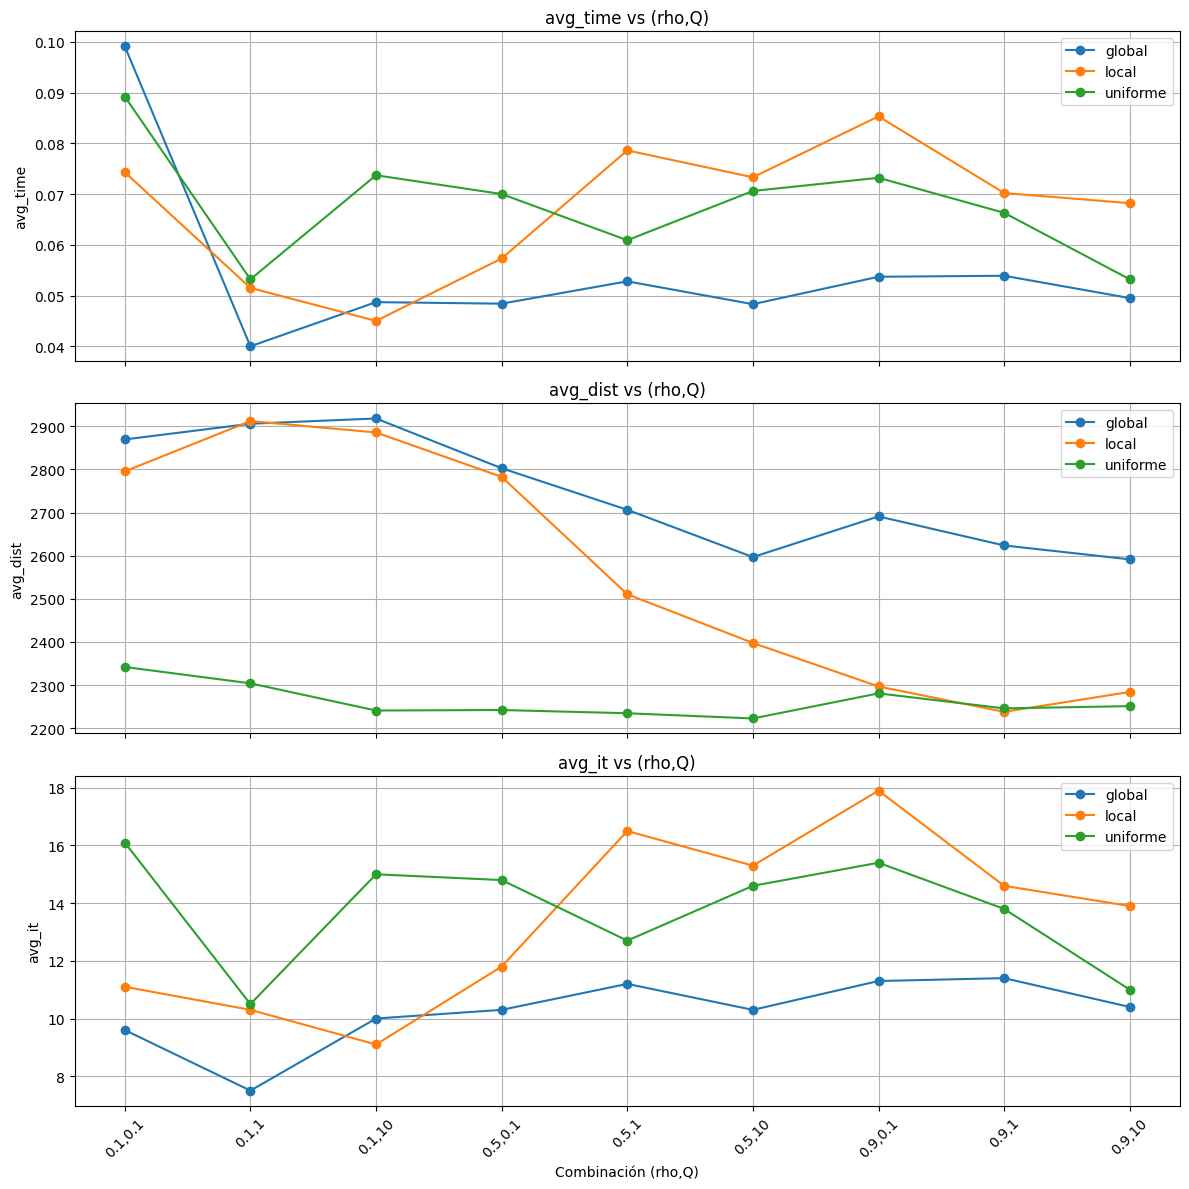

In [3]:
import matplotlib.pyplot as plt

# extraer valores únicos de rho y Q
rho_vals = sorted(set([row[0] for row in resultados._rows]))
Q_vals   = sorted(set([row[1] for row in resultados._rows]))
metodos  = sorted(set([row[2] for row in resultados._rows]))

# generar etiquetas combinadas de parámetros
param_labels = [f"{rho},{q}" for rho in rho_vals for q in Q_vals]

# preparar diccionarios para cada métrica y método
metrics = ['avg_time', 'avg_dist', 'avg_it']
data = {metric: {metodo: [] for metodo in metodos} for metric in metrics}

# llenar datos
for rho in rho_vals:
    for q in Q_vals:
        for metodo in metodos:
            row = [r for r in resultados._rows if r[0]==rho and r[1]==q and r[2]==metodo][0]
            data['avg_time'][metodo].append(float(row[3]))
            data['avg_dist'][metodo].append(float(row[4]))
            data['avg_it'][metodo].append(float(row[5]))

# --- plot ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
for i, metric in enumerate(metrics):
    ax = axes[i]
    for metodo in metodos:
        ax.plot(param_labels, data[metric][metodo], marker='o', label=metodo)
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs (rho,Q)")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Combinación (rho,Q)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
